<a href="https://colab.research.google.com/github/MOvi996/crypto-DL/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tsfresh scipy>=1.5

In [ ]:
import os
import pandas as pd
import numpy as np
import datetime
import tsfresh.utilities.dataframe_functions as df_utilities
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import torch 
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
dr = '/content/drive/MyDrive/'
if not os.path.exists(dr):
  os.makedirs(dr)
os.chdir(dr)

In [ ]:
#run this cell only the first time to clone the repo
#from getpass import getpass
#import urllib

#user = input('User name: ')
#password = getpass('Password: ')
#password = urllib.parse.quote(password)
#cmd_str='git clone https://{}:{}@github.com/dorienh/jesse.git'.format(user,password)
#os.system(cmd_str)
#del password

In [ ]:
#read all the files into a list of dataframes
def preprocess_data(datadir='./jesse/dataset/daily/', add_crypto_id = True):
  #datadir: where all the data files are
  #add_crypto_id: whether to use crypto_ids as a feature
  files = [os.path.join(datadir,f) for f in os.listdir(datadir) if os.path.isfile(os.path.join(datadir, f))]

  df_files=[]
  df_files=[pd.read_csv(f) for f in files]
  crypto_ids = []
  for file in files:
    z= file.split('/')
    z =z[len(z)-1].split('.')[0].split('_')[1]
    crypto_ids.append(z)
  le=LabelEncoder()
  le.fit(crypto_ids)
  #fill all NaN and Inf values
  for df in df_files:
    df.fillna(method='ffill',inplace=True)
    dates=df.date
    df.drop(columns=['date'],inplace=True)
    df*=1.0                     #This indirectly maps all BOOL values to 1's and 0's of type float64
    df_utilities.impute(df)     #This function maps inf->max and -inf->min for each column
    df.insert(0,column='date',value=dates)
  return df_files
  


array([2])

/usr/local/lib/python3.7/dist-packages/tsfresh/utilities/dataframe_functions.py:172: RuntimeWarning: The columns ['SUPERTs_7_3.0'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


Separating all the output columns

In [ ]:
y_cols=['Top_p15_a4',	'Btm_p15_a4',	'Buy_p15_a4',	'Sell_p15_a4',	'Top_p40_a1',	
        'Btm_p40_a1',	'Buy_p40_a1',	'Sell_p40_a1',	'ODR',	'Top',	'Btm',	
        'Trend',	'WM',	'last_pivot']

In [ ]:
def separate_input_output(df_list,y_cols, add_crypto_id = False):
  outputs=[]  #This will contain all the output columns for each df
  inputs=[]   #This will contain all the input columns for each df

  for i,df in enumerate(df_list):
    if add_crypto_id:
      if 'CryptoID' in df.columns:
        del df['CryptoID']

      df.insert(1,'CryptoID',pd.Series(le.transform([crypto_ids[i]]*len(df))))    #adding unique id's for cryptos as an additional feature 
                                                                    #to make sure our model learns the uniqueness of each crypto
    #This step is to take care of any change in the sequence of columns in different files
    if i==0:
      cols=df.columns
    df = df.reindex(columns=cols)
    
    outputs.append(df[y])
    inputs.append(df[[col for col in df.columns if col not in y_cols]])
  return inputs, outputs 

In [ ]:
#set the cols to be predicted here
cols_to_pred=['Buy_p15_a4']

#set this var to false to avoid adding Crypto ID as a feature in the dataset 
crypto_feature=True

X_list, y_list = separate_input_output(df_files.copy(),y=cols_to_pred,add_crypto_id=crypto_feature)

In [ ]:
def split_data(X_list,y_list, test_ratio = 0.2, val_ratio = 0.1):
  #This is an additional step to filter out any crypto df with less than a significant amount of data (atleast 1000 rows).
  #Completely optional
  X_above_1k = []
  y_above_1k = []

  for i in range(len(X_list)):
    if len(X_list[i]) >= 1000:
      X_above_1k.append(X_list[i])
      y_above_1k.append(y_list[i])

  X_train_list = []
  y_train_list = []
  X_test_list = []
  y_test_list = []
  X_val_list = []
  y_val_list = []

  for i in range(len(X_above_1k)):
    X_train, X_test, y_train, y_test = train_test_split(
        X_above_1k[i], y_above_1k[i], test_size = test_ratio, random_state = 42)      #20% for test
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size = val_ratio/(1-test_ratio), random_state = 42)    #0.1/0.8 = 0.125 for val, since 0.8*0.125=10% 
    X_train_list.append(X_train)
    y_train_list.append(y_train)
    X_test_list.append(X_test)
    y_test_list.append(y_test)
    X_val_list.append(X_val)
    y_val_list.append(y_val)
  return X_train_list, y_train_list, X_test_list, y_test_list, X_val_list, y_val_list

In [ ]:
X_train_list, y_train_list, X_test_list, y_test_list, X_val_list, y_val_list = split_data(X_list,y_list, test_ratio = 0.2, val_ratio = 0.1)

Normalizing each dataframe separately

In [ ]:
def normalize(inputs = X_train_list, crypto_id = crypto_feature):
  scalers=[]   #list of scalers
  inputs_mm=[]
  for i in range(len(inputs)):
    scaler = MinMaxScaler()
    if crypto_id:
      input_scaled=scaler.fit_transform(inputs[i].copy().iloc[:,2:]) #leaving out date & cryptoid column
      inputs_mm.append(inputs[i])
      inputs_mm[i].iloc[:,2:]=input_scaled
    else:
      input_scaled=scaler.fit_transform(inputs[i].copy().iloc[:,1:]) #leaving out date column
      inputs_mm.append(inputs[i])
      inputs_mm[i].iloc[:,1:]=input_scaled
    scalers.append(scaler)
  return inputs_mm,scalers

In [ ]:
X_train_mm, scalers = normalize(X_train_list, crypto_id=crypto_feature) #normalization is done only on the training data

In [ ]:
def dimensionality_reduction(inputs, factor = 10, crypto_id=crypto_feature):
  #inputs is the scaled training set
  #factor is the final number of momentum indicators we want (i.e. date, cryptoID, excluding open,high, low and close)
  X_pca = [] 
  reduced_data = []
  for data in inputs:
    if 'date' in data.columns:
      data.index=data.date
      del data['date']
    pca = PCA(n_components=factor)
    if crypto_id:
      non_reduced = np.array(data.iloc[:,:5])     #saving columns cryptoID, open,high, low and close
      pca.fit(data.iloc[:,5:])
      reduced = pca.transform(data.iloc[:,5:])
    else:
      non_reduced = np.array(data.iloc[:,:4])     #saving columns open,high, low and close
      pca.fit(data.iloc[:,4:])
      reduced = pca.transform(data.iloc[:,4:])
    reduced = np.append(non_reduced,reduced,axis=1)
    X_pca.append(pca)
    reduced_data.append(reduced)
  return reduced_data, X_pca

In [ ]:
X_train_reduced, pcas = dimensionality_reduction(X_train_mm, factor = 10) 

In [ ]:
def prepare_test_val_set(inputs_test, inputs_val, scalers, pcas,crypto_id = crypto_feature):
  X_test_mm = []
  X_test_processed = []
  X_val_mm = []
  X_val_processed = []
  for i,df in enumerate(inputs_test):
    if 'date' in df.columns:
      df.index=df.date
      del df['date']
    if crypto_id:
      test_mm = scalers[i].transform(df.copy().iloc[:,1:])     #leaving out cryptoID column
      X_test_mm.append(df)
      X_test_mm[i].iloc[:,1:]=test_mm
      non_reduced = np.array(X_test_mm[i].iloc[:,:5])     #saving columns cryptoID, open,high, low and close
      reduced = pcas[i].transform(X_test_mm[i].iloc[:,5:])
      reduced = np.append(non_reduced,reduced,axis=1)
    else:
      test_mm = scalers[i].transform(df.copy())
      X_test_mm.append(df)
      X_test_mm[i]=test_mm
      non_reduced = np.array(X_test_mm[i].iloc[:,:4])     #saving columns open,high, low and close
      reduced = pcas[i].transform(X_test_mm[i].iloc[:,4:])
      reduced = np.append(non_reduced,reduced,axis=1)
    
    X_test_processed.append(reduced)
  
  for i,df in enumerate(inputs_val):
    if 'date' in df.columns:
      df.index=df.date
      del df['date']
    if crypto_id:
      val_mm = scalers[i].transform(df.copy().iloc[:,1:])     #leaving out cryptoID column
      X_val_mm.append(df)
      X_val_mm[i].iloc[:,1:]=val_mm
      non_reduced = np.array(X_val_mm[i].iloc[:,:5])     #saving columns cryptoID, open,high, low and close
      reduced = pcas[i].transform(X_val_mm[i].iloc[:,5:])
      reduced = np.append(non_reduced,reduced,axis=1)
    else:
      val_mm = scalers[i].transform(df.copy())
      X_val_mm.append(df)
      X_val_mm[i]=val_mm
      non_reduced = np.array(X_val_mm[i].iloc[:,:4])     #saving columns open,high, low and close
      reduced = pcas[i].transform(X_val_mm[i].iloc[:,4:])
      reduced = np.append(non_reduced,reduced,axis=1)
    
    X_val_processed.append(reduced)
  
  return X_test_processed, X_val_processed

In [ ]:
X_test_reduced, X_val_reduced = prepare_test_val_set(X_test_list, X_val_list, scalers, pcas, crypto_id = crypto_feature)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [ ]:
def prepare_tensors(X_train_reduced, X_test_reduced, X_val_reduced, y_train_list, y_test_list, y_val_list):
  #stacking all the data 
  X_train = X_train_reduced[0]
  y_train = np.array(y_train_list[0])
  X_test = X_test_reduced[0]
  y_test = np.array(y_test_list[0])
  X_val = X_val_reduced[0]
  y_val = np.array(y_val_list[0])
  #now we stack all the data 
  for i in range(1,len(X_train_reduced)):
    X_train = np.row_stack((X_train,X_train_reduced[i]))
    y_train = np.row_stack((y_train,np.array(y_train_list[i])))
  for i in range(1,len(X_test_reduced)):
    X_test = np.row_stack((X_test,X_test_reduced[i]))
    y_test = np.row_stack((y_test,np.array(y_test_list[i])))
  for i in range(1,len(X_val_reduced)):
    X_val = np.row_stack((X_val,X_val_reduced[i]))
    y_val = np.row_stack((y_val,np.array(y_val_list[i])))
  
  X_train_tensors = torch.tensor(X_train,dtype=torch.double)
  X_test_tensors = torch.tensor(X_test,dtype=torch.double)
  X_val_tensors = torch.tensor(X_val,dtype=torch.double)

  y_train_tensors = torch.tensor(y_train,dtype=torch.int64)
  y_test_tensors = torch.tensor(y_test,dtype=torch.int64)
  y_val_tensors = torch.tensor(y_val,dtype=torch.int64)
  
  # Their API takes a tensor of shape (sequence length, batch size, dim) if batch_first=False (default) and (batch size, sequence length, dim) if batch_first=True.
  #reshaping to rows, timestamps, features

  X_train_tensors = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
  X_test_tensors = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))
  X_val_tensors = torch.reshape(X_val_tensors,  (X_val_tensors.shape[0], 1, X_val_tensors.shape[1]))

  return X_train_tensors, X_test_tensors, X_val_tensors, y_train_tensors, y_test_tensors, y_val_tensors


In [ ]:
X_train_tensors, X_test_tensors, X_val_tensors, y_train_tensors, y_test_tensors, y_val_tensors = \
prepare_tensors(X_train_reduced, X_test_reduced, X_val_reduced, y_train_list, y_test_list, y_val_list)

In [ ]:
train_data = []
val_data = []
test_data = []
for i in range(len(X_train_tensors)):
   train_data.append([X_train_tensors[i], y_train_tensors[i]])

for i in range(len(X_val_tensors)):
   val_data.append([X_val_tensors[i], y_val_tensors[i]])

for i in range(len(X_test_tensors)):
   test_data.append([X_test_tensors[i], y_test_tensors[i]])


In [ ]:
batch_size = 64
loader_train=DataLoader(train_data,
                       batch_size=batch_size,
                       shuffle=True)
loader_val=DataLoader(val_data,
                      batch_size=batch_size,
                      shuffle=False)
loader_test=DataLoader(test_data,
                       batch_size=batch_size,
                       shuffle=False)

loaders=  {'train': loader_train,
           'valid': loader_val,
           'test': loader_test}

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Tensor(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Tensor(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
def save_metrics(save_path, train_loss_list, valid_loss_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list}
    
    torch.save(state_dict, save_path)
    print(f'Metrics saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path)
    print(f'Metrics loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list']

In [ ]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes  # number of classes
        self.num_layers = num_layers  # number of layers
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # hidden state
        self.seq_length = seq_length  # sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout = 0.2)  # lstm
        self.fc_1 = nn.Linear(hidden_size*2, 128)  # fully connected 1
        self.fc = nn.Linear(128, num_classes)  # fully connected last layer

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        h_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)  # hidden state

        c_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)  # internal state

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))  # lstm with input, hidden, and internal state
        hn = hn.view(x.size(0),-1)  # reshaping the data for Dense layer next
        out = self.relu(hn)

        out = self.fc_1(out)  # first Dense

        out = self.relu(out)  # relu

        out = self.fc(out)  # Final Output
        out = self.sigmoid(out)

        return out

In [ ]:
def train(n_epochs, model, loaders,  optimizer, criterion):
    """returns trained model"""
    valid_loss_min = np.Inf 
    model.float()    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        # train the model 
        model.train()

        for batch_idx, (data, target) in enumerate(loaders['train']):
            #if use_cuda:
            #    data, target = data.cuda(), target.cuda()
            data = data.float()
            optimizer.zero_grad()    
            output=model(data)#.double())
            loss=criterion(output,target.long())
            loss.backward()
            optimizer.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))    

        # validate the model 
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            #if use_cuda:
            #    data, target = data.cuda(), target.cuda()
            data = data.float()
            output=model(data)#.double())
            loss=criterion(output,target.long())
            valid_loss+=((1/(batch_idx + 1))*(loss.data - valid_loss))
            model.eval()

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        if valid_loss < valid_loss_min:
            print('validation loss decreased from {:.6f} to {:.6f}. Model is being saved.'.format(
                valid_loss_min,
                valid_loss))
            
            valid_loss_min=valid_loss
            torch.save(model.state_dict(),f'/content/drive/MyDrive/Jesse/Models/{datetime.datetime.now()}_LSTM1.pt')
        
        # return trained model
    return model

In [ ]:
str(datetime.datetime.now())

'2021-04-01 00:28:11.870078'

In [ ]:
num_epochs = 10 #100 epochs
learning_rate = 0.0003 #0.001 lr

input_size = 15 #number of features (this does not include date)
hidden_size = 8 #number of features in hidden state
num_layers = 2  #number of stacked lstm layers
num_classes = 2 #number of output classes

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors.shape[1]) #our lstm class

criterion = FocalLoss(gamma = 2,alpha = 0.25) 
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

lstm1 = train(num_epochs,lstm1, loaders, optimizer, criterion)

print('Finished Training!')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: 0.016454 	Validation Loss: 0.013731
validation loss decreased from inf to 0.013731. Model is being saved.
Epoch: 2 	Training Loss: 0.014231 	Validation Loss: 0.013668
validation loss decreased from 0.013731 to 0.013668. Model is being saved.
Epoch: 3 	Training Loss: 0.014199 	Validation Loss: 0.013644
validation loss decreased from 0.013668 to 0.013644. Model is being saved.
Epoch: 4 	Training Loss: 0.014185 	Validation Loss: 0.013639
validation loss decreased from 0.013644 to 0.013639. Model is being saved.
Epoch: 5 	Training Loss: 0.014181 	Validation Loss: 0.013630
validation loss decreased from 0.013639 to 0.013630. Model is being saved.
Epoch: 6 	Training Loss: 0.014198 	Validation Loss: 0.013624
validation loss decreased from 0.013630 to 0.013624. Model is being saved.
Epoch: 7 	Training Loss: 0.014196 	Validation Loss: 0.013623
validation loss decreased from 0.013624 to 0.013623. Model is being saved.
Epoch: 8 	Training Loss: 0.014173 	Validation Loss: 0

Metrics loaded from <== /content/drive/MyDrive/Jesse/Metrics/lstm1.pt


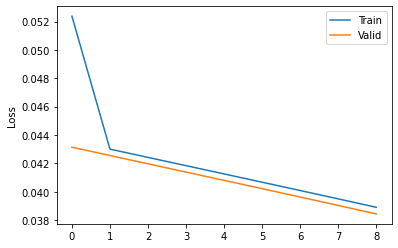

In [ ]:
train_loss_list, valid_loss_list = load_metrics('/content/drive/MyDrive/Jesse/Metrics' + '/lstm1.pt')
plt.plot(train_loss_list, label='Train')
plt.plot(valid_loss_list, label='Valid')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [ ]:
#Here you need to specify the name of the last/best model you wanna load 
lstm1.load_state_dict(torch.load('/content/drive/MyDrive/Jesse/Models/2021-03-31 22:03:29.503644_LSTM1.pt'))

(tensor([], dtype=torch.int64),
 tensor([], dtype=torch.int64),
 tensor([], dtype=torch.int64))

In [ ]:

predictions=lstm1(X_test_tensors.float()).detach().numpy()
#predictions=predictions

In [ ]:
for idx in np.unique(np.where(np.isnan(predictions))[0]).tolist():
  predictions=np.delete(predictions,idx, axis = 0)
  y_test_tensors=np.delete(y_test_tensors,idx, axis = 0)

In [ ]:
def evaluate(predictions,y_test_tensors):
  print(f'Accuracy:  {accuracy_score(y_test_tensors, np.round(predictions[:,1]))}')
  print(f'Confusion Matrix: \n{confusion_matrix(y_test_tensors, np.round(predictions[:,1]))}')
  print(f'Precision: {precision_score(y_test_tensors, np.round(predictions[:,1]))}')
  print(f'AOC Curve: {roc_auc_score(y_test_tensors, np.round(predictions[:,1]))}')

In [ ]:
evaluate(predictions, y_test_tensors)

Accuracy:  0.984870771170414
Confusion Matrix: 
[[28122     0]
 [  432     0]]
Precision: 0.0
AOC Curve: 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


28557

In [ ]:
class TransformerModel(nn.Module):

    def __init__(self, nmod, ninp, nhead, nhid, nlayers, dropout=0.3):
        """nmod:
              Model input dimension. (usually the vocab size in text classification problems)
          ninp:
              dimension of input to the model
          d_output:
              Model output dimension.
          nhead:
              Number of heads.
          nhid:
              the dimension of the feedforward network model in nn.TransformerEncoder
          nlayers:
              Number of encoder and decoder layers to stack.
          dropout:
              Default is ``0.3``.
            """
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Linear(nmod,ninp)       #linear layer instead of embedding layer
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, nmod)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        output = self.relu(output)
        output = self.sigmoid(output)

        return output

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
nmod = 2 # the size of possible outcome (usually vocab size in text applications)
ninp = 16 # dimension of input vector
nhid = 8 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
transformer = TransformerModel(nmod, ninp, nhead, nhid, nlayers, dropout)

In [ ]:
bptt = len(X_train_tensors)
""""
#Will use it later on if needed
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target
"""

'"\n#Will use it later on if needed\ndef get_batch(source, i):\n    seq_len = min(bptt, len(source) - 1 - i)\n    data = source[i:i+seq_len]\n    target = source[i+1:i+1+seq_len].reshape(-1)\n    return data, target\n'

In [ ]:
eval_freq = 5 #perform validation every 5 epochs
learning_rate = 0.3
num_epochs = 50 #100 epochs

#weights= torch.Tensor([(98103/1621)*10,98103/98103]) 
criterion = FocalLoss(gamma = 2,alpha = 0.25) 
optimizer = torch.optim.Adam(transformer.parameters(), lr=learning_rate)


running_loss=0
train_loss_list=[]
val_loss_list=[]
for epoch in range(num_epochs):
    transformer.train()
    src_mask = transformer.generate_square_subsequent_mask(bptt)
    
    outputs = transformer.forward(X_train_tensors,src_mask)  # forward pass
    optimizer.zero_grad()  # caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs, y_train_tensors[:,0].long())

    loss.backward()  # calculates the loss of the loss function

    optimizer.step()  # improve from loss, i.e backprop

    running_loss+=loss.item()

    if epoch % eval_freq == 0 and epoch > 0:
      transformer.eval()
      output = transformer(X_val_tensors)
      valid_loss = criterion.forward(output, y_val_tensors[:,0].long())
      transformer.train()
    
      print("Epoch: %d, Train_loss: %1.5f, Val_loss: %1.5f" % (epoch, running_loss/eval_freq, valid_loss.item()))
      
      train_loss_list.append(running_loss/eval_freq)
      val_loss_list.append(valid_loss)
      
      running_loss=0


save_metrics('/content/drive/MyDrive/Jesse/Metrics' + '/transformer.pt', train_loss_list, val_loss_list)
torch.save(transformer,f'/content/drive/MyDrive/Jesse/Models/Transformers/{datetime.datetime.now()}_transormer.pt')
print('Finished Training!')

In [ ]:
!pip freeze > requirements.txt